# Combining gone fishing (BAIT) with Fisher mask (FISH)

Fisher mask code in FISH folder

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet18

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = resnet18(pretrained=True)

cpu


c:\Users\JoshC\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\JoshC\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
w = model.conv1.weight.grad
type(w)

Next steps:

* download the dataset cifar10, and create a dataloader  with appropriate preprocessing
* iterate over minibatches from dataloader, calculate crossentropy loss, 
* in typical sgd training, we zero out the gradients before processing the next minibatch. this is done by calling model.zero_grad(), and then calling model.backward() to get the new gradients. Since we are not interested in training right now, we want the sum of gradients over all minibatches. so we should not call model.zero_grad()
* identify the top 2% of all the weights in the model and make a new pk x k array, where p = 2% of the total number of parameters.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import resnet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#using the paper's model definition from resnet.py
model = resnet.ResNet18()

#arguments from run.py
cifar_args = {'n_epoch': 3, 'transform': transforms.Compose([ 
                     transforms.RandomCrop(32, padding=4),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor(),
                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                 ]),
                 'loader_tr_args':{'batch_size': 128, 'num_workers': 1},
                 'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
                 'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                 'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
            }
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_args['transform'])
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=cifar_args['loader_tr_args']['batch_size'], num_workers=cifar_args['loader_tr_args']['num_workers'], shuffle=True)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_args['transform'])
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=cifar_args['loader_te_args']['batch_size'], num_workers=cifar_args['loader_te_args']['num_workers'], shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=cifar_args['optimizer_args']['lr'], momentum=cifar_args['optimizer_args']['momentum'])

In [ ]:
for name, param in model.named_parameters():
    if name.__contains__("weight"):
        print(name, param.grad.size())

In [ ]:
for epoch in range(1):#cifar_args['n_epoch']):
    running_loss = 0.0
    for i, data in enumerate(cifar_trainloader):
        inputs, labels = data
        #we omit the step of zeroing gradients here
        outputs, emb = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        #print(model.layer1[0].conv1.weight.grad) #how to access gradients of layers
        optimizer.step()
        running_loss += loss.item()
        for name, param in model.named_parameters():
            if name.__contains__("weight"):
                print(name, param.grad)
print('Done Training.')

Files already downloaded and verified
Files already downloaded and verified


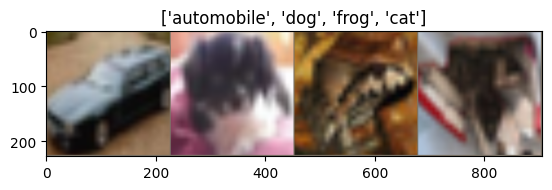

In [3]:
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.datasets as datasets
import torchvision
import torch
import time
import copy
import matplotlib.pyplot as plt
import numpy as np

# Using pretrained weights:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
preprocess = ResNet18_Weights.DEFAULT.transforms()
processed_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
class_names = processed_trainset.classes
processed_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
dataloaders = {'train' : [], 'val' : []}
dataloaders['train'] = torch.utils.data.DataLoader(processed_trainset, batch_size=128,
                                                    shuffle=True, num_workers=4, pin_memory=True)
dataloaders['val'] = torch.utils.data.DataLoader(processed_testset, batch_size=128,
                                                    shuffle=False, num_workers=4, pin_memory=True)
dataset_sizes = {'train' : len(processed_trainset), 'val' : len(processed_testset)}


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # same as in preprocess
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

Sanity Check

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Complete our sanity check to ensure training helps accuracy as it should
model.eval()
running_loss = 0.0
running_corrects = 0
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']
    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


In [ ]:
# freeze all pretrained weights 
for param in model.parameters():
    param.requires_grad = False

# Replace last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_conv,
                    exp_lr_scheduler, num_epochs=5)

Identifying the most important weights

In [12]:
import torch.nn.functional as F
import numpy as np

testloader = torch.utils.data.DataLoader(processed_testset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
for param in model.parameters():
    param.requires_grad = True

model.zero_grad()

testbatch, testlabels = next(iter(testloader))
outputs = model(testbatch.to(device))
prob = F.softmax(outputs, dim=1).unsqueeze(-1).unsqueeze(-1)
log_probs = F.log_softmax(outputs, dim=1)
N, C = log_probs.shape

parameters = tuple(model.parameters())
fim_dict = {i: [] for i in range(len(parameters))}
for n in range(N):
    for c in range(C):
        grad_list = torch.autograd.grad(log_probs[n][c], parameters, retain_graph=True)
        for i, grad in enumerate(grad_list):
            flatten_grad = grad.flatten()
            fim = flatten_grad.unsqueeze(1) * flatten_grad.unsqueeze(0)
            fim_dict[i].append(fim.detach().clone())

# Need to calculate the expected value squared and sum them up over all test data and divide by the number of test data

RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 86973087744 bytes.